# HW5 problem 1

Seokjun Choi


*Code blocks are Python scripts in this problem.*

*Executable stand-alone Python script: https://github.com/letsjdosth/GLM/blob/main/hw5q1.py*

*This code depends on third-party packages*
- numpy
- matplotlib

and another python module that I implemented,
- MCMC_Core: *https://github.com/letsjdosth/GLM/blob/main/pyBayes/MCMC_Core.py*

*All scripts are tested in Python 3.10.5 64-bit, in Windows 10.*

Let me start with setting the given dataset and some functions used for (a) and (b).

In [1]:
from random import seed, normalvariate, gammavariate, uniform
from math import log, exp, lgamma, inf
from functools import partial

import matplotlib.pyplot as plt
import numpy as np

from pyBayes import MCMC_Core

seed(20221201)

x_fabric_length = [551, 651, 832, 375, 715, 868, 271, 630, 491, 372, 645, 441, 895, 458, 642, 492, 543, 842, 905, 542, 522, 122, 657, 170, 738, 371, 735, 749, 495, 716, 952, 417]
y_fabric_faults = [6, 4, 17, 9, 14, 8, 5, 7, 7, 7, 6, 8, 28, 4, 10, 4, 8, 9, 23, 9, 6, 1, 9, 4, 9, 14, 17, 10, 7, 3, 9, 2]
y_x_fabric = [(y, x) for y, x in zip(y_fabric_faults, x_fabric_length)]

def symmetric_proposal_placeholder(from_smpl, to_smpl):
    #for log_proposal
    return 0

def normal_proposal_sampler(from_smpl, proposal_sigma_vec):
    return [normalvariate(x, proposal_sigma_vec[i]) for i,x in enumerate(from_smpl)]

def unif_proposal_log_pdf(from_smpl, to_smpl, window):
    applied_window = [max(0, from_smpl-window/2), from_smpl+window/2]
    if to_smpl<applied_window[0] or to_smpl>applied_window[1]:
        return -inf
    else:
        applied_window_len = applied_window[1] - applied_window[0]
        return 1/applied_window_len

def unif_proposal_sampler(from_smpl, window):
    applied_window = [max(0, from_smpl-window/2), from_smpl+window/2]
    return uniform(applied_window[0], applied_window[1])

def post_pred_resid_plot(predictive_samples): #depend on data (not first-class function!)
    x_grid = x_fabric_length
    boxplot_frame = []
    for i, (obs_y, _) in enumerate(y_x_fabric):
        res_samples_at_x = [y_new - obs_y for y_new in predictive_samples[i]]
        boxplot_frame.append(res_samples_at_x)

    plt.figure(figsize=(12,5))
    plt.boxplot(np.transpose(boxplot_frame), labels=x_grid)
    plt.axhline(0)
    plt.tight_layout()
    plt.show()

def loss_L_measure(predictive_samples, k): #depend on data (not first-class function!)
    loss = 0
    for i, (obs_y, _) in enumerate(y_x_fabric):
        predictive_var_at_x = np.var(predictive_samples[i])
        predictive_mean_at_x = np.mean(predictive_samples[i])
        loss += (predictive_var_at_x + (k/(k+1))*(obs_y-predictive_mean_at_x)**2)
    return loss

## 1-(a)

I fit the non-hierarchical Poisson model.

I use the improper flat prior for $\beta_1, \beta_2$. 

For MCMC iteration, two candidate betas are proposed simultaneously, using a multivariate normal distribution.

In [2]:
#problem 1a
def q1a_log_posterior_with_flat_prior(beta, y_x):
    #beta: [beta1, beta2]
    log_post = 0
    for y, x in y_x:
        nu = beta[0] + beta[1] * x
        log_post += (y*nu - exp(nu))
    return log_post


def q1a_mu_plot(posterior_samples, set_x_axis, show=True): #depend on data (not first-class function!)
    x_grid = np.arange(set_x_axis[0], set_x_axis[1], set_x_axis[2])
    mu_lwr = [] #I
    mu_med = []
    mu_upr = []
    mu_avg = []

    for x in x_grid:
        mu_samples_at_x = []

        for beta in posterior_samples:
            mu_samples_at_x.append(exp(beta[0]+beta[1]*x))

        mu_lwr.append(float(np.quantile(mu_samples_at_x, 0.025)))
        mu_med.append(float(np.quantile(mu_samples_at_x, 0.5)))
        mu_upr.append(float(np.quantile(mu_samples_at_x, 0.975)))
        mu_avg.append(float(np.mean(mu_samples_at_x)))

    plt.ylim([0, 30])
    plt.plot(x_grid, mu_avg, color="black", linestyle="solid")
    plt.plot(x_grid, mu_med, color="black", linestyle="dashed")
    plt.plot(x_grid, mu_lwr, color="grey")
    plt.plot(x_grid, mu_upr, color="grey")

    plt.plot(x_fabric_length, y_fabric_faults, marker="o", color="black", linestyle="none")
    
    if show:
        plt.show()

def q1a_generate_predictive_samples(posterior_samples): #depend on data (not first-class function!)
    predictive_samples = []
    for x in x_fabric_length:
        pred_samples_at_x = []
        for beta in posterior_samples:
            mu_at_x = exp(beta[0]+beta[1]*x)
            pred_samples_at_x.append(np.random.poisson(mu_at_x))
        predictive_samples.append(pred_samples_at_x)
    return predictive_samples

q1a_initial = [0,0]
q1a_inst = MCMC_Core.MCMC_MH(
                partial(q1a_log_posterior_with_flat_prior, y_x=y_x_fabric),
                symmetric_proposal_placeholder,
                partial(normal_proposal_sampler, proposal_sigma_vec=[0.15, 0.0003]),
                q1a_initial)
q1a_inst.generate_samples(50000, print_iter_cycle=10000)


estimated running time:  0.0 min  1.01470947265625 sec
iteration 10000 / 50000
iteration 20000 / 50000
iteration 30000 / 50000
iteration 40000 / 50000
iteration 50000 / 50000  done! (elapsed time for execution:  0.0 min  1.163029670715332 sec)
acceptance rate:  0.2529


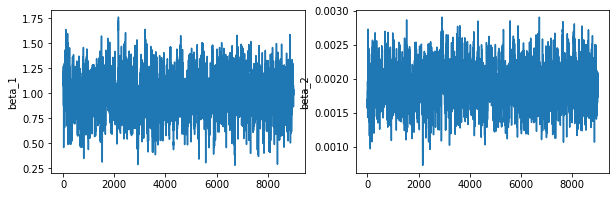

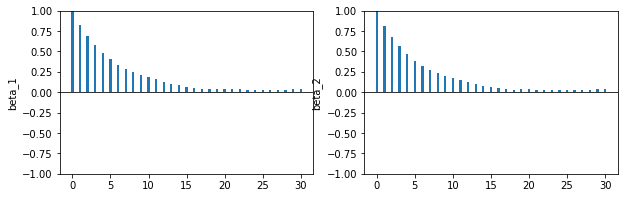

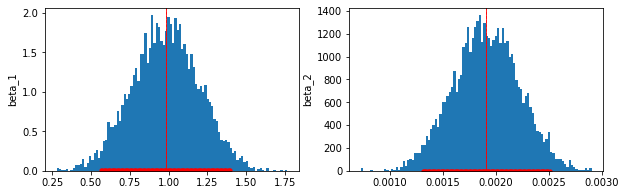

param 		 mean 	 var 	 95%CI
beta_1 		 0.980827 	 0.046208 	 [0.565698, 1.396102]
beta_2 		 0.00191 	 0.0 	 [0.001307, 0.002508]


In [3]:
q1a_diag = MCMC_Core.MCMC_Diag()
q1a_diag.set_mc_sample_from_MCMC_instance(q1a_inst)
q1a_diag.set_variable_names(["beta_1", "beta_2"])
q1a_diag.burnin(5000)
q1a_diag.thinning(5)

q1a_diag.show_traceplot((1,2))
q1a_diag.show_acf(30, (1,2))
q1a_diag.show_hist((1,2))
q1a_diag.print_summaries(6)

From top to bottom, traceplots, ACF plots, and histograms with mean(vertical red line), median(vertical dashed line), and 95% centered credible interval(horizontal red line) are shown. Not only that, I attached a summary table for parameters.

Convergence looks fine.

We can directly interpret $\beta_1$ and $\beta_2$ using the posterior distributions.
But, an easier way is to see a plot for $\mu$, like below.

Here are the $\mu$ versus $x$ plot, posterior predictive residual plot, and quadratic loss measures at some $k$ values.

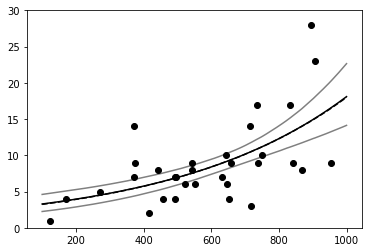

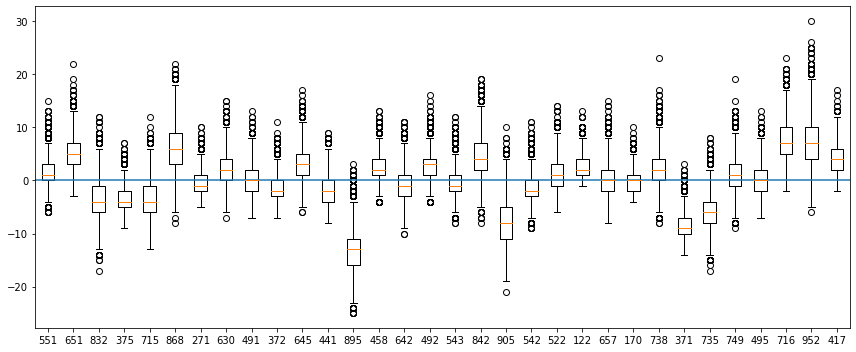

quadratic loss measure, k=1 : 628.5347385453264
quadratic loss measure, k=2 : 736.9486487906146
quadratic loss measure, k=5 : 845.3625590359029
quadratic loss measure, k=10 : 894.6416091473974


In [4]:
q1a_mu_plot(q1a_diag.MC_sample, (100, 1000, 1))

q1a_predictive_samples = q1a_generate_predictive_samples(q1a_diag.MC_sample)
post_pred_resid_plot(q1a_predictive_samples)
print("quadratic loss measure, k=1 :", loss_L_measure(q1a_predictive_samples, 1))
print("quadratic loss measure, k=2 :", loss_L_measure(q1a_predictive_samples, 2))
print("quadratic loss measure, k=5 :", loss_L_measure(q1a_predictive_samples, 5))
print("quadratic loss measure, k=10 :", loss_L_measure(q1a_predictive_samples, 10))

On the $\mu$ vs $x$ plot, the black solid curve indicates the posterior mean, and two gray curves mark the 95% centered credible interval of $\mu$.
Black dots are observations in the dataset. 

The $\mu$ vs $x$ plot shows a problem of this fit.
The credible interval is too narrow compared to observations.
In other words, our model could only catch the dispersion of data partially.

We can draw a similar conclusion when we see the second plot, the posterior predictive residual plot.
Even if each boxplot's whiskers cover zero except for two observation points, many boxes do not.
It is because the data have a big dispersion.

I will comment on the quadratic loss measure later, comparing this fitting result with the fit of (b).

## 1-(b)

For fitting the hierarchical Poisson GLM, I will use MH-within-Gibbs, as I noted.
The class *Q1b_Gibbs* is the implementation of the algorithm.

I use the flat prior for $\beta_1, \beta_2$, and set $p(\lambda) \propto (1+\lambda)^{-2}$.

In [5]:
#problem 1b
class Q1b_Gibbs(MCMC_Core.MCMC_Gibbs):
    def __init__(self, initial, y_x):
        self.MC_sample = [initial]
        self.y_x = y_x

    def _full_conditional_beta(self, last_param):
        new_param = last_param
        # 0                1                    2
        # [[beta1, beta2], [mu1, mu2,...,mu_n], lambda]
        def gibbs_beta_log_posterior_with_flat_prior(beta, mu_vec, lamb, y_x):
            log_post = 0
            for (_, x), mu in zip(y_x, mu_vec):
                nu = beta[0] + beta[1] * x
                log_post += ((-lamb)*(nu + mu * exp(-nu)))
            return log_post
        
        initial = last_param[0]
        mc_mh_inst = MCMC_Core.MCMC_MH(
                        partial(gibbs_beta_log_posterior_with_flat_prior, mu_vec=last_param[1], lamb=last_param[2], y_x=self.y_x),
                        symmetric_proposal_placeholder,
                        partial(normal_proposal_sampler, proposal_sigma_vec=[0.6, 0.0005]),
                        initial)
        mc_mh_inst.generate_samples(2, verbose=False)
        new_beta = mc_mh_inst.MC_sample[-1]
        new_param[0] = new_beta
        return new_param

    def _full_conditional_mu(self, last_param):
        new_param = last_param
        # 0                1                    2
        # [[beta1, beta2], [mu1, mu2,...,mu_n], lambda]
        new_mu = last_param[1]
        for i, (y, x) in enumerate(self.y_x):
            nu = last_param[0][0] + last_param[0][1] * x
            lamb = last_param[2]
            new_mu[i] = gammavariate(lamb+y, 1/(1+lamb*exp(-nu)))
        new_param[1] = new_mu
        return new_param

    def _full_conditional_lambda(self, last_param):
        new_param = last_param
        # 0                1                    2
        # [[beta1, beta2], [mu1, mu2,...,mu_n], lambda]
        def gibbs_lambda_log_posterior_with_1_prior(lamb, beta, mu_vec, y_x):
            log_post = 0
            for (_, x), mu in zip(y_x, mu_vec):
                nu = beta[0] + beta[1] * x
                log_post += (log(mu) - nu - mu*exp(-nu))
            log_post += (len(y_x)*log(lamb))
            log_post *= lamb
            log_post -= (len(y_x)*lgamma(lamb))
            return log_post

        def gibbs_lambda_log_posterior_with_invquad_prior(lamb, beta, mu_vec, y_x): 
            ## for prior sensitivity analysis!
            log_post = gibbs_lambda_log_posterior_with_1_prior(lamb, beta, mu_vec, y_x)
            log_post += (-2*log(lamb+1))
            return log_post
        
        def gibbs_lambda_log_posterior_with_gamma_prior(lamb, beta, mu_vec, y_x): 
            ## for prior sensitivity analysis!
            log_post = gibbs_lambda_log_posterior_with_1_prior(lamb, beta, mu_vec, y_x)
            a = 2
            b = 2
            log_post += ((a-1)*log(lamb) - b*lamb)
            return log_post

        initial = last_param[2]
        window = 10
        mc_mh_inst = MCMC_Core.MCMC_MH(
                        partial(gibbs_lambda_log_posterior_with_invquad_prior, beta = last_param[0], mu_vec=last_param[1], y_x=self.y_x),
                        partial(unif_proposal_log_pdf, window=window),
                        partial(unif_proposal_sampler, window=window),
                        initial)
        mc_mh_inst.generate_samples(2, verbose=False)
        new_lamb = mc_mh_inst.MC_sample[-1]
        new_param[2] = new_lamb
        return new_param

    def sampler(self, **kwargs):
        # [[beta1, beta2], [mu1, mu2,...,mu_n], lambda]
        last = self.MC_sample[-1]
        new = self.deep_copier(last)
        
        #update new
        new = self._full_conditional_beta(new)
        new = self._full_conditional_mu(new)
        new = self._full_conditional_lambda(new)
        self.MC_sample.append(new)


def q1b_mu_plot(posterior_beta_lambda_samples, set_x_axis, show=True): #depend on data (not first-class function!)
    x_grid = np.arange(set_x_axis[0], set_x_axis[1], set_x_axis[2])
    mu_lwr = []
    mu_med = []
    mu_upr = []
    mu_avg = []

    for x in x_grid:
        mu_samples_at_x = []

        for beta_lambda in posterior_beta_lambda_samples:
            lamb = beta_lambda[2]
            gamma_at_x = exp(beta_lambda[0]+beta_lambda[1]*x)
            mu_samples_at_x.append(gammavariate(lamb, 1/(lamb/gamma_at_x)))

        mu_lwr.append(float(np.quantile(mu_samples_at_x, 0.025)))
        mu_med.append(float(np.quantile(mu_samples_at_x, 0.5)))
        mu_upr.append(float(np.quantile(mu_samples_at_x, 0.975)))
        mu_avg.append(float(np.mean(mu_samples_at_x)))

    plt.ylim([0, 30])
    plt.plot(x_grid, mu_avg, color="black", linestyle="solid")
    plt.plot(x_grid, mu_med, color="black", linestyle="dashed")
    plt.plot(x_grid, mu_lwr, color="grey")
    plt.plot(x_grid, mu_upr, color="grey")

    plt.plot(x_fabric_length, y_fabric_faults, marker="o", color="black", linestyle="none")
    
    if show:
        plt.show()

def q1b_generate_predictive_samples(posterior_mu_samples): #depend on data (not first-class function!)
    predictive_samples = [[] for _ in range(len(x_fabric_length))]
    for mu in posterior_mu_samples:
        for i, m_i in enumerate(mu):
            predictive_samples[i].append(np.random.poisson(m_i))
    return predictive_samples



q1b_initial = [[0,0], [0 for _ in range(len(y_x_fabric))], 0.5]
q1b_inst = Q1b_Gibbs(q1b_initial, y_x_fabric)
q1b_inst.generate_samples(50000, print_iter_cycle=10000)


estimated running time:  0.0 min  7.393121719360352 sec
iteration 10000 / 50000
iteration 20000 / 50000
iteration 30000 / 50000
iteration 40000 / 50000
iteration 50000 / 50000  done! (elapsed time for execution:  0.0 min  7.536517143249512 sec)


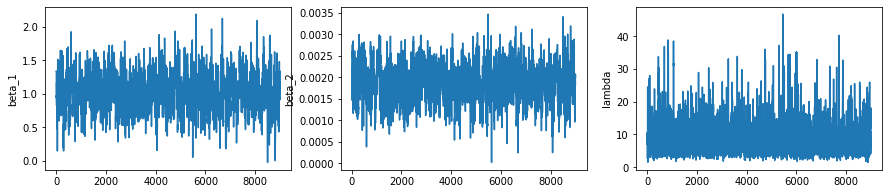

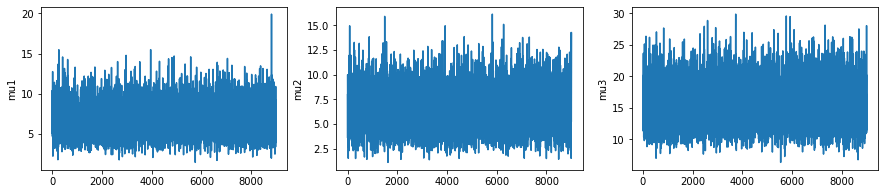

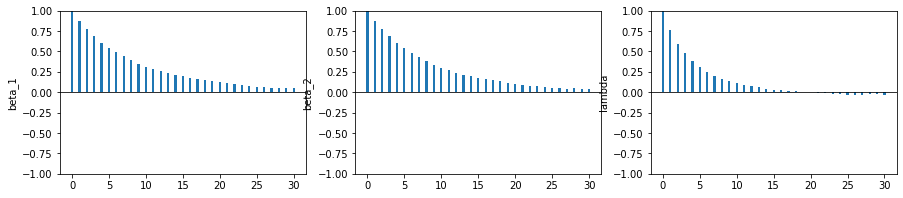

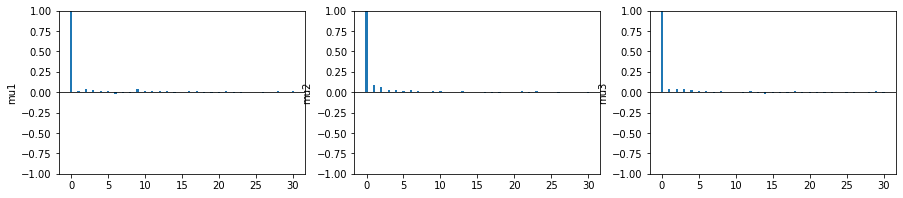

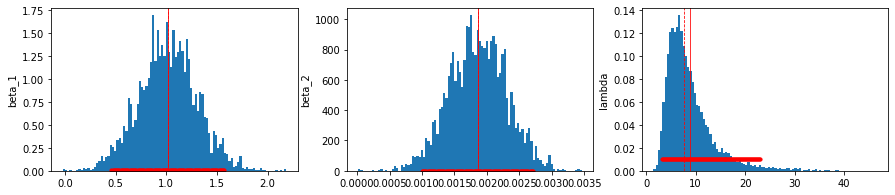

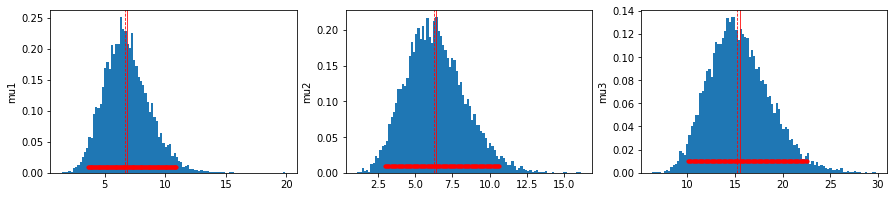

param 		 mean 	 var 	 95%CI
beta_1 		 1.016435 	 0.081887 	 [0.458175, 1.572912]
beta_2 		 0.001859 	 0.0 	 [0.001, 0.00271]
lambda 		 8.882248 	 25.368929 	 [3.228409, 23.039278]
param 		 mean 	 var 	 95%CI
mu1 		 6.828059 	 3.540221 	 [3.598261, 10.903911]
mu2 		 6.393999 	 3.947721 	 [2.968681, 10.667525]
mu3 		 15.514738 	 10.346279 	 [10.044371, 22.54224]
mu4 		 6.989086 	 3.397902 	 [3.916404, 11.10685]
mu5 		 12.404319 	 7.206683 	 [7.755589, 18.237407]
mu6 		 10.124923 	 7.213644 	 [5.537029, 16.068215]
mu7 		 4.731997 	 2.09601 	 [2.415796, 8.012843]
mu8 		 7.850569 	 4.297613 	 [4.280598, 12.458033]
mu9 		 6.956898 	 3.471578 	 [3.766821, 11.109686]
mu10 		 6.166589 	 2.927957 	 [3.321615, 10.026256]
mu11 		 7.446971 	 4.097917 	 [3.895869, 11.87835]
mu12 		 7.027481 	 3.33408 	 [3.960502, 11.074654]
mu13 		 23.207781 	 18.982743 	 [15.579051, 32.596997]
mu14 		 5.332255 	 2.603835 	 [2.576226, 8.942903]
mu15 		 9.581491 	 5.287059 	 [5.542388, 14.635236]
mu16 		 5.547769 	 2

In [8]:
q1b_diag1 = MCMC_Core.MCMC_Diag()
q1b_MC_samples1 = [t[0] + [t[2]] for t in q1b_inst.MC_sample]
q1b_diag1.set_mc_samples_from_list(q1b_MC_samples1)
q1b_diag1.set_variable_names(["beta_1", "beta_2", "lambda"])
q1b_diag1.burnin(5000)
q1b_diag1.thinning(5)

q1b_diag2 = MCMC_Core.MCMC_Diag()
q1b_MC_samples1 = [t[1] for t in q1b_inst.MC_sample]
q1b_diag2.set_mc_samples_from_list(q1b_MC_samples1)
q1b_diag2.set_variable_names(["mu"+str(i+1) for i in range(len(y_x_fabric))])
q1b_diag2.burnin(5000)
q1b_diag2.thinning(5)

q1b_diag1.show_traceplot((1,3))
q1b_diag2.show_traceplot((1,3), [0,1,2])
q1b_diag1.show_acf(30, (1,3))
q1b_diag2.show_acf(30, (1,3), [0,1,2])
q1b_diag1.show_hist((1,3))
q1b_diag2.show_hist((1,3), [0,1,2])

q1b_diag1.print_summaries(6)
q1b_diag2.print_summaries(6)

Again, from top to bottom, traceplots, ACF plots, and histograms with mean(vertical red line), median(vertical dashed line), and 95% centered credible interval(horizontal red line) are shown. Please see the y label for the parameter name. 
Because there are 32 $\mu_i$ s, I print plots of the first three $\mu_1, \mu_2, \mu_3$ only.

I made a summary table for parameters, too.

Convergence looks fine.

The traceplots show that each $\mu_i$ varies within a wide range by a higher layer, which makes over-dispersion for $y_i$.

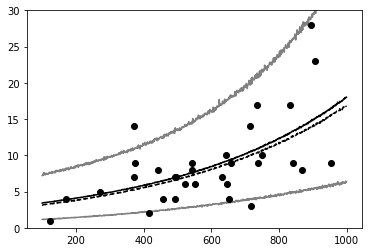

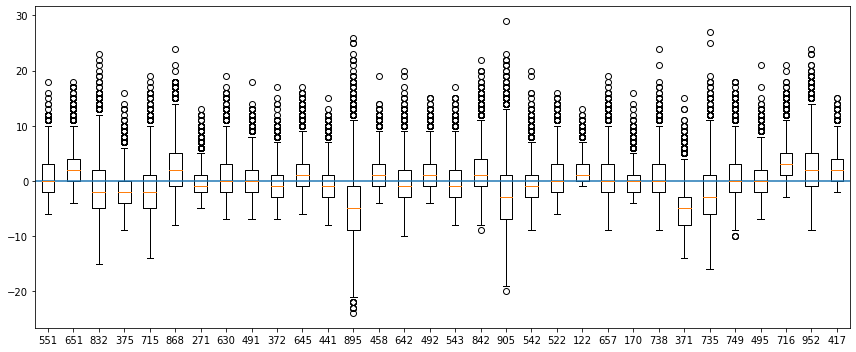

quadratic loss measure, k=1 : 514.0122228947614
quadratic loss measure, k=2 : 533.8652385494756
quadratic loss measure, k=5 : 553.7182542041902
quadratic loss measure, k=10 : 562.7423522290603


In [9]:
q1b_mu_plot(q1b_diag1.MC_sample, (100, 1000, 1))

q1b_predictive_samples = q1b_generate_predictive_samples(q1b_diag2.MC_sample)
post_pred_resid_plot(q1b_predictive_samples)
print("quadratic loss measure, k=1 :", loss_L_measure(q1b_predictive_samples, 1))
print("quadratic loss measure, k=2 :", loss_L_measure(q1b_predictive_samples, 2))
print("quadratic loss measure, k=5 :", loss_L_measure(q1b_predictive_samples, 5))
print("quadratic loss measure, k=10 :", loss_L_measure(q1b_predictive_samples, 10))

This model's $\mu$ versus $x$ plot looks better than (a)'s. The credible interval makes sense, covering almost all observations.
The posterior predictive residual plots are also much better than (a)'s result. Now, many 'box' parts cover zero.

For all four $k$ s, the quadratic loss measures here are lower than (a)'s values, meaning that the fit of (b) is better than of (a).

### Short note of prior sensitivity analysis for model (b)

By changing the second argument when assigning *mc_mh_inst* in the *Q1b_Gibbs._full_conditional_lambda* method, we can easily do a prior sensitivity analysis.
I tried some gamma priors with different hyper-parameters, and generally, they work well. (for example, gamma(2,2) yields a similar result with $(1+\lambda)^{-2})$.)
But I skip reporting other cases here.

But it is known that the prior specification for $\lambda$ is crucial for hierarchical GLMs.
For example, in one of my last STAT207 homework, over-dispersion parameters got to 0 by a poor prior, even if the data obviously has a large variance.
If you are interested in seeing how I messed it up, here is the link... ->  https://1drv.ms/b/s!AqetV36Oe2hvgslb2GbYO6jDeV2_7g?e=qABijJ